In [262]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import numpy as np
import datetime
import math
import warnings

## Monthly Prices and Returns

In [534]:
def monthly_close_prices(ticker):
    stock_prices = yf.download(ticker, start="2000-01-01", end=pd.to_datetime('today'))
    m_close_prices = stock_prices[['Close']].resample('M').last()
    return m_close_prices

def monthly_return(ticker):    
    m_close_prices = monthly_close_prices(ticker)
    m_close_prices['Return'] = m_close_prices['Close'].pct_change()
    return m_close_prices

def only_return(ticker):
    global port_stock_stat
    m_returns_series = monthly_return(ticker)
    port_stock_stat['tickers'].append(ticker)
    port_stock_stat['returns'].append(m_returns_series['Return'].dropna().values.flatten())


# Individual Stock Statsitics

In [535]:
def stock_stats():
    global stats
    for ticker in tickers:
        if not any(ticker in element for element in port_stock_stat['tickers']):
            only_return(ticker)
            index = port_stock_stat['tickers'].index(ticker)
            returns = port_stock_stat['returns'][index]
            row = pd.DataFrame({
                'Ticker': [ticker],
                'Expected_Return': [returns.mean()],
                'Variance': [returns.var()],
                'Standard_Deviation': [returns.std()]
            })
            stats = pd.concat([stats, row], ignore_index=True)
    return stats




# Arrays: Returns, Covariance, Correlation, Weights

In [536]:
def mu_matrix():
    mu_mat = stats['Expected_Return']
    return mu_mat

def cov_matrix():
    cov_mat = pd.DataFrame(index=tickers, columns=tickers)

    for row_tick in tickers:
        for col_tick in tickers:
            returns_y = pd.Series(port_stock_stat['returns'][port_stock_stat['tickers'].index(row_tick)])
            returns_x = pd.Series(port_stock_stat['returns'][port_stock_stat['tickers'].index(col_tick)])
            cov_xy = returns_y.cov(returns_x)
            cov_mat.loc[row_tick, col_tick] = cov_xy
    
    return cov_mat

def cor_matrix():
    cor_mat = pd.DataFrame(index = tickers, columns = tickers)

    for row_tick in tickers:
        for col_tick in tickers:
            returns_y = pd.Series(port_stock_stat['returns'][port_stock_stat['tickers'].index(row_tick)])
            returns_x = pd.Series(port_stock_stat['returns'][port_stock_stat['tickers'].index(col_tick)])
            cor_xy = returns_y.corr(returns_x)
            cor_mat.loc[row_tick, col_tick] = cor_xy

    return cor_mat

def weights_matrix():
    global weights
    while (sum(weights) != 1.0):
        print("Please Re-Enter weights that add up to 1")
    return(weights)


# Portfolio Stats: Return, SD, Variance

In [537]:
def portfolio_stats(current_weights = None):
    global port_stats
    stock_stats()
    if current_weights is None or current_weights.any() is None:
        current_weights = weights
    mu_mat = mu_matrix()
    cov_mat = cov_matrix()

    port_e_return = np.dot(np.transpose(current_weights), mu_mat.values)
    port_var = np.dot(np.dot(np.transpose(current_weights),cov_mat), current_weights)
    port_sd = math.sqrt(port_var)
    port_stats = [port_e_return, port_sd, port_var]
    return port_stats

def print_portfolio_stats(current_weights = None):

    current_port_stats = portfolio_stats(current_weights)
    print('Expected Portfolio Return:', round(current_port_stats[0],4))
    print('Portfolio Return Standard Deviation:', round(current_port_stats[1], 4))
    print('Portfolio Return Variance:', round(current_port_stats[2], 4))

# Minimum Risk Calculation

In [538]:
def min_risk_portfolio():
    cov_mat = cov_matrix()
    top_mat = np.column_stack([2 * cov_mat, np.ones(len(tickers))])
    bot_vec = np.concatenate([np.ones(len(tickers)), [0]])
    
    Am_mat = np.vstack((top_mat, bot_vec))
    b_vec = np.concatenate([np.zeros(len(tickers)), [1]])
    Am_mat = Am_mat.astype(np.float64)
    b_vec = b_vec.astype(np.float64)
    sol_mat = np.linalg.solve(Am_mat, b_vec)
    return pd.DataFrame({'Ticker': tickers, 'Weight': sol_mat[:-1]})


# Same Expected Returns Calculation

In [539]:
def same_return_portfolio(ticker):
    cov_mat = cov_matrix()  
    mu_mat = mu_matrix()
    ticker_return = pd.to_numeric(stats[stats['Ticker'] == ticker]['Expected_Return'].values, errors='coerce')

    top_mat = np.column_stack([2*cov_mat, mu_mat, np.ones(len(tickers))])
    mid_vec = np.append(stats['Expected_Return'].values, [0, 0])
    bot_vec = np.concatenate([np.ones(len(tickers)), [0, 0]])

    Ax_mat = np.row_stack((top_mat, mid_vec, bot_vec)).astype(float)
    ticker_vec = np.concatenate([np.zeros(len(tickers)), ticker_return, [0]])


    sol_mat = np.linalg.solve(Ax_mat, ticker_vec)
    return pd.DataFrame({'Ticker': tickers, 'Weight': sol_mat[:len(mu_mat)]})


# Efficient Portfolio Calculation

In [568]:
def efficient_portfolio():
    cov_mat = cov_matrix().astype(float)
    sigma_inv_mat = np.linalg.inv(cov_mat.values)
    one_vec = np.ones(len(tickers))
    mu_minus_rf = mu_matrix() - rf * one_vec
    top_mat = np.dot(sigma_inv_mat, mu_minus_rf)
    bot_val = np.dot(np.transpose(one_vec), top_mat)
    t_vec = top_mat / bot_val

    bill_perc = 1 - t_vec.sum()
    all_inv = tickers + ['T-Bills']

    efficient_df = pd.DataFrame({'Ticker': all_inv, 'Weight': np.round(np.append(t_vec, bill_perc), 4)})

    return efficient_df

def e_portfolio_stats():
    cov_mat = cov_matrix().astype(float)
    sigma_inv_mat = np.linalg.inv(cov_mat.values)
    one_vec = np.ones(len(tickers))
    mu_minus_rf = mu_matrix() - rf * one_vec
    top_mat = np.dot(sigma_inv_mat, mu_minus_rf)
    bot_val = np.dot(np.transpose(one_vec), top_mat)
    t_vec = top_mat / bot_val
    
    expected_return = np.dot(t_vec, mu_matrix())
    standard_deviation = np.sqrt(np.dot(np.dot(t_vec, cov_matrix()), t_vec))

    return [expected_return, standard_deviation]

def print_e_port_stats():
    e_port = e_portfolio_stats()
    print('Expected Portfolio Return:', round(e_port[0],4))
    print('Portfolio Return Standard Deviation:', round(e_port[1], 4))
    print('Portfolio Return Variance:', round(e_port[1]**2, 4))

# Risk Return Scatter Plot

In [543]:
def rr_plot():
    all_stats = stock_stats()
    # Scatter plot
    plt.scatter(all_stats['Standard_Deviation'], all_stats['Expected_Return'], label=tickers)

    # Labeling the points with ticker names
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (all_stats.iloc[i]['Standard_Deviation'], all_stats.iloc[i]['Expected_Return']))

    portfolio_stats()
    plt.scatter(port_stats[1], port_stats[0], color = 'red', label = 'Your Portfolio')
    plt.annotate('Your Portfolio', (port_stats[1], port_stats[0]))

    min_risk_port = min_risk_portfolio()
    min_risk_port_stats = portfolio_stats(min_risk_port['Weight'])

    plt.scatter(min_risk_port_stats[1], min_risk_port_stats[0], color = 'green', label = 'Min Risk')
    plt.annotate('Min Risk', (min_risk_port_stats[1], min_risk_port_stats[0]))

    
    efficient_port = e_portfolio_stats()
    plt.scatter(efficient_port[1], efficient_port[0], color = 'orange', label = 'Most Efficient')
    plt.annotate('Most Efficient', (efficient_port[1], efficient_port[0]))


    # Add labels and title
    plt.xlabel('Standard Deviation')
    plt.ylabel('Expected Return')
    plt.title('Risk-Return Scatter Plot')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

# Information

In [571]:
tickers = ['MSFT', 'AMD', 'SPY', 'NKE']
weights = [0.1518, 0.167, 0.129, 0.1588]
stats = pd.DataFrame()
port_stock_stat = {'tickers': [],'returns': []}
port_stat = []
apy = 0.02
rf = (1 + apy) ** (1 / 12) - 1
stock_stats()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Ticker,Expected_Return,Variance,Standard_Deviation
0,MSFT,0.010459,0.006490,0.080561
1,AMD,0.024741,0.035523,0.188474
2,SPY,0.005266,0.001986,0.044566
3,NKE,0.013167,0.006088,0.078024


# Portfolio Frontier

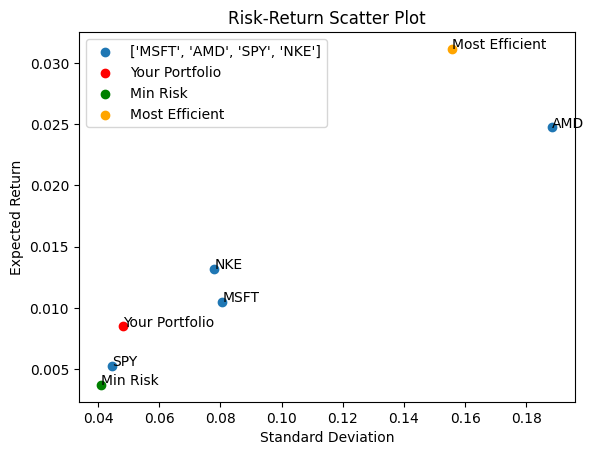

In [549]:
rr_plot()


# Your Portfolio

In [547]:
print('Your Portfolio:')
print_portfolio_stats()
stats

Your Portfolio:
Expected Portfolio Return: 0.0085
Portfolio Return Standard Deviation: 0.0482
Portfolio Return Variance: 0.0023


,Ticker,Expected_Return,Variance,Standard_Deviation
0,MSFT,0.010459,0.006490,0.080561
1,AMD,0.024741,0.035523,0.188474
2,SPY,0.005266,0.001986,0.044566
3,NKE,0.013167,0.006088,0.078024


# Min Risk Portfolio

In [555]:
min_risk_port = min_risk_portfolio()
print('Min Risk Portfolio:')
print_portfolio_stats(min_risk_port['Weight'])
min_risk_port

Min Risk Portfolio:
Expected Portfolio Return: 0.0037
Portfolio Return Standard Deviation: 0.041
Portfolio Return Variance: 0.0017


,Ticker,Weight
0,MSFT,-0.004722
1,AMD,-0.101996
2,SPY,1.050053
3,NKE,0.056665


# Most Efficient Portfolio

In [569]:
print('Most Efficient Portfolio:')
print_e_port_stats()
efficient_portfolio()

Most Efficient Portfolio:
Expected Portfolio Return: 0.0312
Portfolio Return Standard Deviation: 0.1556
Portfolio Return Variance: 0.0242


,Ticker,Weight
0,MSFT,1.0035
1,AMD,0.4313
2,SPY,-1.9891
3,NKE,1.5543
4,T-Bills,-0.0000
